In [2]:


import jax
import jax.numpy as jnp
import numpy as np

from IPython.display import HTML
import matplotlib.animation as anim
import matplotlib.pyplot as plt
# import plotly.graph_objects as go

import hj_reachability as hj



In [3]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [4]:
class DoubleIntegrator(hj.ControlAndDisturbanceAffineDynamics):

    def __init__(self, 
                 max_acceleration=1.,
                 max_disturbance=0.0,
                 control_mode="max", 
                 disturbance_mode="min",
                 control_space = None,
                 disturbance_space = None):

        if control_space is None:
            control_space = hj.sets.Box(jnp.array([-max_acceleration]),
                                        jnp.array([max_acceleration]) )

        if disturbance_space is None:
            disturbance_space = hj.sets.Ball(jnp.zeros(1), max_disturbance)

        super().__init__(control_mode, disturbance_mode, control_space, disturbance_space)


    def open_loop_dynamics(self, state, time):
        v = state[1]
        return jnp.array([v, 0.])

    def control_jacobian(self, state, time):
        return jnp.array( [
            [0.,],
            [1.,]
        ])

    def disturbance_jacobian(self, state, time):
        return jnp.array( [
            [0.,],
            [1.,]
        ])
        

In [5]:
dynamics = DoubleIntegrator()

In [6]:
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(lo=np.array([0., -1.]),
                                                                           hi=np.array([2., 2.])),
                                                               (40, 40,), periodic_dims=[])

In [7]:
grid.states.shape

(40, 40, 2)

In [8]:
(1.5 - grid.states[:, :, 0]).shape

(40, 40)

In [9]:
grid.states[..., :2].shape

(40, 40, 2)

In [10]:
(grid.coordinate_vectors[0])

Array([0.        , 0.05128205, 0.1025641 , 0.15384616, 0.20512821,
       0.25641027, 0.30769232, 0.35897437, 0.41025642, 0.46153846,
       0.51282054, 0.5641026 , 0.61538464, 0.6666667 , 0.71794873,
       0.7692308 , 0.82051283, 0.8717949 , 0.9230769 , 0.974359  ,
       1.0256411 , 1.0769231 , 1.1282052 , 1.1794872 , 1.2307693 ,
       1.2820513 , 1.3333334 , 1.3846154 , 1.4358975 , 1.4871795 ,
       1.5384616 , 1.5897436 , 1.6410257 , 1.6923077 , 1.7435898 ,
       1.7948718 , 1.8461539 , 1.8974359 , 1.948718  , 2.        ],      dtype=float32)

In [11]:
values = (1.5 - grid.states[:, :, 0])
# values= jnp.linalg.norm(grid.states[..., :2], axis=-1) - 2

In [12]:
values.shape

(40, 40)

<Figure size 640x480 with 0 Axes>

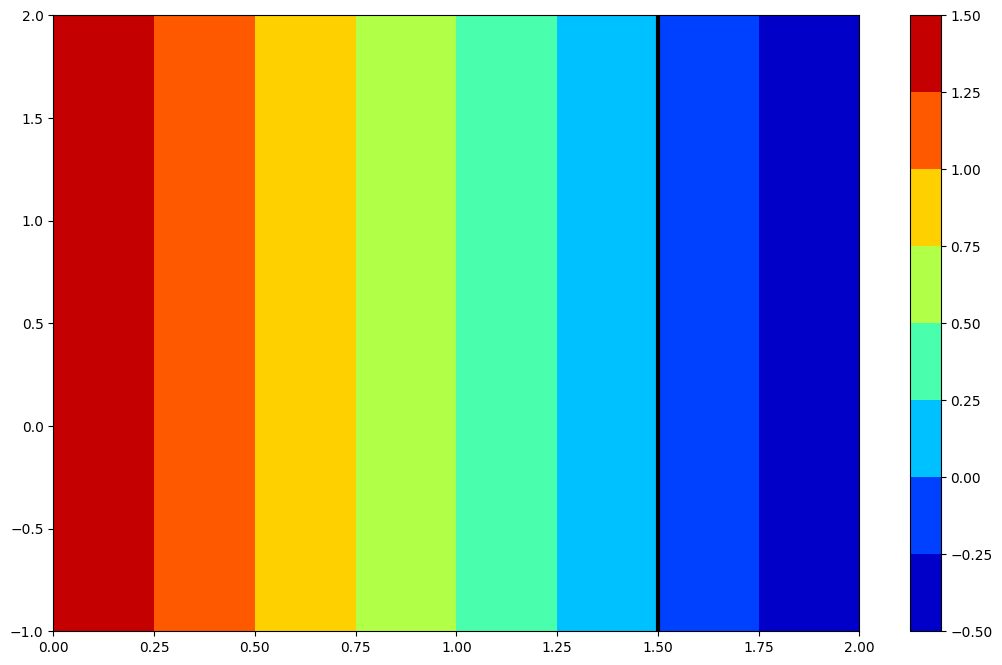

In [13]:


plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], values.T)
plt.colorbar()
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            values[:, :].T,
            levels=0,
            colors="black",
            linewidths=3)



In [14]:
solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                 hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)
time = 0.
target_time = -1.0
target_values = hj.step(solver_settings, dynamics, grid, time, values, target_time)

100%|############################################################################################################################################################################################################################|  1.0000/1.0 [00:00<00:00, 284.21sim_s/s]


<Figure size 640x480 with 0 Axes>

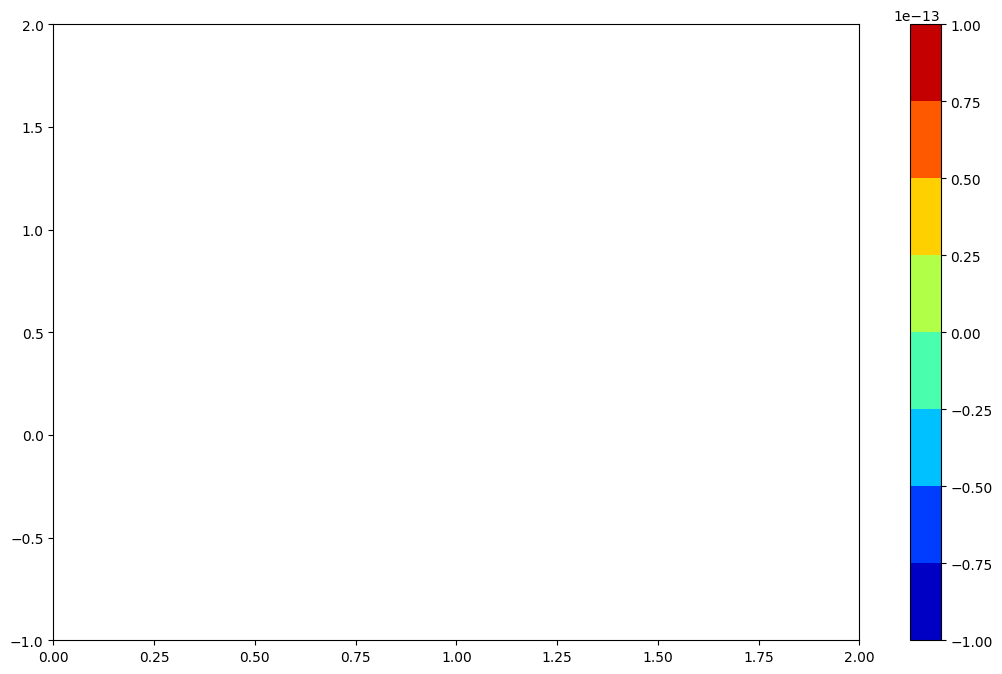

In [15]:

plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values.T)
plt.colorbar()
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            target_values[:, :].T,
            levels=0,
            colors="black",
            linewidths=3)


In [16]:
target_values

Array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [17]:
jnp.any(jnp.isnan(target_values))

Array(True, dtype=bool)